# Introduction

## Background

The dataset comprises a diverse range of macromolecules with biological significance, wherein the majority of records pertain to proteins. Proteins play a crucial role in biological pathways and cycles by directly interacting with other biomolecules. Typically, proteins perform specific functions that are defined by their family type. For instance, a Hydrolase group protein catalyzes hydrolysis, which helps in breaking protein or other molecular chains. Similarly, a transport protein facilitates the movement of various molecules, such as sucrose, fructose, or water, in and out of the cell. It is important to note that DNA, as the precursor to RNA, plays a crucial role in the translation of proteins.

## Goals

The existence of diverse protein family types raises the question of whether it is feasible to identify a protein's family type based on its sequence. While search engines like BLAST can perform this task, exploring the efficacy of a machine learning approach in classifying a protein's family type based on its sequence would be intriguing.

In [1]:
# 1). ----- Import Libraries and Datasets ------

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# original data from PDB
# Import Datasets
df_seq = pd.read_csv('./pdb_data_seq.csv')
df_char = pd.read_csv('./pdb_data_no_dups.csv')

print('Datasets have been loaded...')

Datasets have been loaded...


In [2]:
# 2). ----- Filter and Process Dataset ------

# Filter for only proteins
protein_char = df_char[df_char.macromoleculeType == 'Protein']
protein_seq = df_seq[df_seq.macromoleculeType == 'Protein']

# Select only necessary variables to join
protein_char = protein_char[['structureId','classification']]
protein_seq = protein_seq[['structureId','sequence']]

protein_seq.head()

,structureId,sequence
4,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [3]:
protein_char.head()

,structureId,classification
2,101M,OXYGEN TRANSPORT
4,102L,HYDROLASE(O-GLYCOSYL)
5,102M,OXYGEN TRANSPORT
7,103L,HYDROLASE(O-GLYCOSYL)
8,103M,OXYGEN TRANSPORT


In [4]:
# Join two datasets on structureId
model_f = protein_char.set_index('structureId').join(protein_seq.set_index('structureId'))
model_f.head()

,classification,sequence
structureId,,
101M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
102L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
102M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
103L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
103M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [5]:
print('%d is the number of rows in the joined dataset' %model_f.shape[0])

346325 is the number of rows in the joined dataset


In [6]:
# Check NA counts
model_f.isnull().sum()

classification    1
sequence          3
dtype: int64

In [7]:
# Drop rows with missing values
model_f = model_f.dropna()
print('%d is the number of proteins that have a classification and sequence' %model_f.shape[0])

346321 is the number of proteins that have a classification and sequence


HYDROLASE                            46336
TRANSFERASE                          36424
OXIDOREDUCTASE                       34321
IMMUNE SYSTEM                        15615
LYASE                                11682
                                     ...  
STRUCTURAL PROTEIN, CELL CYCLE           1
KINASE (GLYCOGEN METABOLISM)             1
SURFACE GLYCOPROTEIN                     1
IMMUNE SYSTEM,HYDROLASE INHIBITOR        1
antimicrobial                            1
Name: classification, Length: 4468, dtype: int64


/apps/python/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


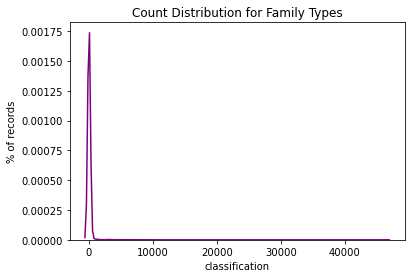

In [8]:
# Look at classification type counts
counts = model_f.classification.value_counts()
print(counts)

#plot counts
plt.figure()
sns.distplot(counts, hist = False, color = 'purple')
plt.title('Count Distribution for Family Types')
plt.ylabel('% of records')
plt.show()

In [9]:
# Get classification types where counts are over 1000
types = np.asarray(counts[(counts > 1000)].index)

# Filter dataset's records for classification types > 1000
data = model_f[model_f.classification.isin(types)]

print(types)
print('%d is the number of records in the final filtered dataset' %data.shape[0])

['HYDROLASE' 'TRANSFERASE' 'OXIDOREDUCTASE' 'IMMUNE SYSTEM' 'LYASE'
 'HYDROLASE/HYDROLASE INHIBITOR' 'TRANSCRIPTION' 'VIRAL PROTEIN'
 'TRANSPORT PROTEIN' 'VIRUS' 'SIGNALING PROTEIN' 'ISOMERASE' 'LIGASE'
 'MEMBRANE PROTEIN' 'PROTEIN BINDING' 'STRUCTURAL PROTEIN' 'CHAPERONE'
 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION' 'SUGAR BINDING PROTEIN'
 'DNA BINDING PROTEIN' 'PHOTOSYNTHESIS' 'ELECTRON TRANSPORT'
 'TRANSFERASE/TRANSFERASE INHIBITOR' 'METAL BINDING PROTEIN'
 'CELL ADHESION' 'UNKNOWN FUNCTION' 'PROTEIN TRANSPORT' 'TOXIN'
 'CELL CYCLE' 'RNA BINDING PROTEIN' 'DE NOVO PROTEIN' 'HORMONE'
 'GENE REGULATION' 'OXIDOREDUCTASE/OXIDOREDUCTASE INHIBITOR' 'APOPTOSIS'
 'MOTOR PROTEIN' 'PROTEIN FIBRIL' 'METAL TRANSPORT'
 'VIRAL PROTEIN/IMMUNE SYSTEM' 'CONTRACTILE PROTEIN' 'FLUORESCENT PROTEIN'
 'TRANSLATION' 'BIOSYNTHETIC PROTEIN']
278866 is the number of records in the final filtered dataset


In [10]:
# 3). ----- Train Test Split -----

# Split Data
X_train, X_test,y_train,y_test = train_test_split(data['sequence'], data['classification'], test_size = 0.2, random_state = 1)

# Create a Count Vectorizer to gather the unique elements in sequence
vect = CountVectorizer(analyzer = 'char_wb', ngram_range = (4,4))

# Fit and Transform CountVectorizer
vect.fit(X_train)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

#Print a few of the features
print(vect.get_feature_names()[-20:])

['zhhh', 'ziar', 'zigi', 'ziwz', 'zkal', 'zkky', 'zknt', 'zkyh', 'zlik', 'zlzk', 'zpvm', 'zrgd', 'zrvi', 'ztvl', 'ztzk', 'zvbd', 'zvib', 'zvka', 'zwdl', 'zzvb']


/apps/python/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [11]:
# 4). ------ Machine Learning Models ------

# Make a prediction dictionary to store accuracys
prediction = dict()

# Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_df, y_train)
NB_pred = model.predict(X_test_df)
prediction["MultinomialNB"] = accuracy_score(NB_pred, y_test)
print( prediction['MultinomialNB'])

0.7638505396779861


<AxesSubplot:>

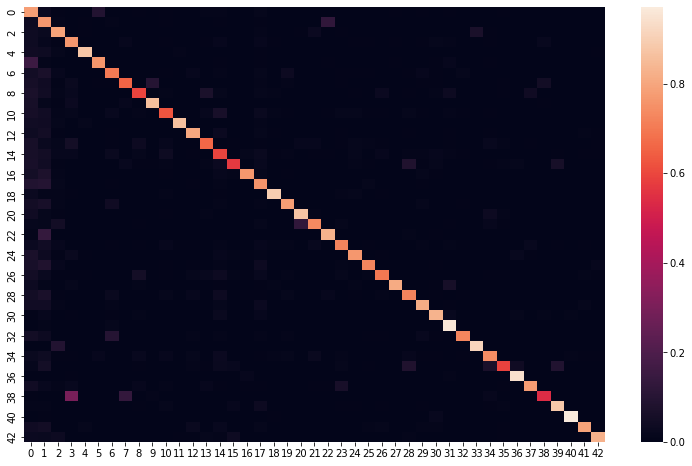

In [12]:
# 5). ----- Plot Confusion Matrix for NB -----

# Plot confusion matrix
conf_mat = confusion_matrix(y_test, NB_pred, labels = types)

#Normalize confusion_matrix
conf_mat = conf_mat.astype('float')/ conf_mat.sum(axis=1)[:, np.newaxis]

# Plot Heat Map
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.heatmap(conf_mat)

In [13]:
print(types[3])
print(types[38])

IMMUNE SYSTEM
VIRAL PROTEIN/IMMUNE SYSTEM


In [14]:
#Print F1 score metrics
print(classification_report(y_test, NB_pred, target_names = types))

                                         precision    recall  f1-score   support

                              HYDROLASE       0.47      0.74      0.57       250
                            TRANSFERASE       0.60      0.82      0.70       211
                         OXIDOREDUCTASE       0.75      0.77      0.76       589
                          IMMUNE SYSTEM       0.66      0.72      0.69       509
                                  LYASE       0.91      0.76      0.83       859
          HYDROLASE/HYDROLASE INHIBITOR       0.66      0.88      0.76       224
                          TRANSCRIPTION       0.58      0.83      0.68       326
                          VIRAL PROTEIN       0.71      0.78      0.75       622
                      TRANSPORT PROTEIN       0.60      0.74      0.66       601
                                  VIRUS       0.91      0.97      0.94       209
                      SIGNALING PROTEIN       0.71      0.73      0.72       309
                           

# Improvement for the model

Utilizing factors such as pH, molecular weight, and other components may be able to yield more information on family group. 
### In this model, we try to imporve for the model by adding a additional factor (resolution<2.0).  

In [15]:
# 1). ----- Import Libraries and Datasets ------

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Import Datasets
df_seq = pd.read_csv('pdb_data_seq.csv')
df_char = pd.read_csv('pdb_data_no_dups.csv')

print('Datasets have been loaded...')


Datasets have been loaded...


In [16]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
# 2). ----- Filter and Process Dataset ------

# Filter for only proteins
protein_char = df_char[df_char.macromoleculeType == 'Protein']
protein_seq = df_seq[df_seq.macromoleculeType == 'Protein']
# add resolution as parameter 
protein_char = protein_char[['structureId','classification','resolution']]
protein_seq = protein_seq[['structureId','sequence']]
protein_seq.head()

,structureId,sequence
4,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [18]:
protein_char.head()

,structureId,classification,resolution
2,101M,OXYGEN TRANSPORT,2.07
4,102L,HYDROLASE(O-GLYCOSYL),1.74
5,102M,OXYGEN TRANSPORT,1.84
7,103L,HYDROLASE(O-GLYCOSYL),1.90
8,103M,OXYGEN TRANSPORT,2.07


In [19]:
# Join two datasets on structureId
model_f = protein_char.set_index('structureId').join(protein_seq.set_index('structureId'))
model_f.head()

,classification,resolution,sequence
structureId,,,
101M,OXYGEN TRANSPORT,2.07,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
102L,HYDROLASE(O-GLYCOSYL),1.74,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
102M,OXYGEN TRANSPORT,1.84,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
103L,HYDROLASE(O-GLYCOSYL),1.90,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
103M,OXYGEN TRANSPORT,2.07,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [20]:
print('%d is the number of rows in the joined dataset' %model_f.shape[0])

346325 is the number of rows in the joined dataset


In [21]:
# Check NA counts
model_f.isnull().sum()

classification        1
resolution        16093
sequence              3
dtype: int64

In [22]:
# Drop rows with missing values and filtered the protein of resolution less than 2.0 
model_f = model_f.dropna()
filtered_proteins = model_f[model_f['resolution'] < 2.0]
print(filtered_proteins.describe())
print('%d is the number of proteins that have a classification and sequence' %filtered_proteins.shape[0])

         resolution
count  99721.000000
mean       1.693001
std        0.225696
min        0.480000
25%        1.570000
50%        1.750000
75%        1.890000
max        1.990000
99721 is the number of proteins that have a classification and sequence


With 99721 proteins, it appears that simply removing missing values is acceptable.

Lastly, it's important to look at the types of family groups that clasification can be.

HYDROLASE                                 16978
OXIDOREDUCTASE                            12323
TRANSFERASE                               10679
LYASE                                      4768
IMMUNE SYSTEM                              3514
                                          ...  
RNA BINDING PROTEIN/STRUCTURAL PROTEIN        1
Oxioreductase/substrate                       1
Structural genomics, transferase              1
DNA REPLICATION                               1
HYDROLASE (SULFHYDRYL PROTEINASE)             1
Name: classification, Length: 1868, dtype: int64


/apps/python/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


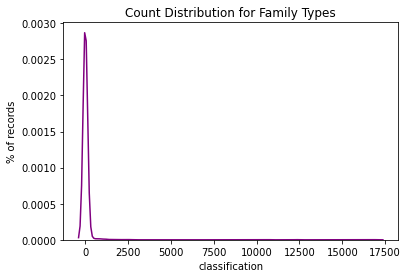

In [23]:
# Look at classification type counts
counts = filtered_proteins.classification.value_counts()
print(counts)

#plot counts
plt.figure()
sns.distplot(counts, hist = False, color = 'purple')
plt.title('Count Distribution for Family Types')
plt.ylabel('% of records')
plt.show()

/apps/python/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


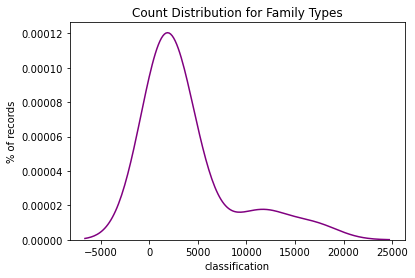

['HYDROLASE' 'OXIDOREDUCTASE' 'TRANSFERASE' 'LYASE' 'IMMUNE SYSTEM'
 'ISOMERASE' 'HYDROLASE/HYDROLASE INHIBITOR' 'TRANSCRIPTION'
 'TRANSPORT PROTEIN' 'SUGAR BINDING PROTEIN' 'SIGNALING PROTEIN'
 'VIRAL PROTEIN' 'PROTEIN BINDING' 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION'
 'UNKNOWN FUNCTION' 'ELECTRON TRANSPORT' 'LIGASE' 'METAL BINDING PROTEIN']
69621 is the number of records in the final filtered dataset


In [24]:
# Get classification types where counts are over 1000
types = np.asarray(counts[(counts > 1000)].index)

# Filter dataset's records for classification types > 1000
data = filtered_proteins[filtered_proteins.classification.isin(types)]

# Count occurrences of each classification type
classification_counts = data.classification.value_counts()

# Plot counts
plt.figure()
sns.distplot(classification_counts, hist=False, color='purple')
plt.title('Count Distribution for Family Types')
plt.ylabel('% of records')
plt.show()

print(types)
print('%d is the number of records in the final filtered dataset' % data.shape[0])

## Train Test Split
Once the dataset has been filtered, the data should be split into training and testing sets. To extract features from the training dataset, the CountVectorizer should be employed to create a dictionary. This involves extracting individual characters or subsets of characters. It is important to note that the ngram_range needs to be specified appropriately.

In proteins, identification of their purpose is not based solely on the individual amino acids. Rather, it is the result of the secondary and tertiary structures formed by the amino acid sequence's bonds. Moreover, different parts of the chain can be more acidic or basic. Therefore, it is crucial to use features that are larger than a single unit. Setting an ngram_range of (4,4) appears to be a reasonable choice for feature extraction. This will extract different subsets of length 4, allowing the amino acids to use their neighbors to aid in classification.

In [25]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['sequence'], data['classification'], test_size=0.2, random_state=1)

# Filter based on resolution
train_res = data[data['sequence'].isin(X_train)]
test_res = data[data['sequence'].isin(X_test)]
train_res = train_res[train_res['resolution'].between(0, 2)]
test_res = test_res[test_res['resolution'].between(0, 2)]

# Filter based on classification types
types = np.asarray(data['classification'].value_counts()[data['classification'].value_counts() > 1000].index)
train_res = train_res[train_res['classification'].isin(types)]
test_res = test_res[test_res['classification'].isin(types)]

# Create CountVectorizer to extract features from sequences
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(analyzer='char_wb', ngram_range=(4,4))

# Fit and transform CountVectorizer on training data
vect.fit(train_res['sequence'])
X_train_df = vect.transform(train_res['sequence'])
X_test_df = vect.transform(test_res['sequence'])

print(vect.get_feature_names_out()[-20:])

['yyy ' 'yyya' 'yyyd' 'yyye' 'yyyf' 'yyyg' 'yyyh' 'yyyi' 'yyyk' 'yyyl'
 'yyym' 'yyyn' 'yyyp' 'yyyq' 'yyyr' 'yyys' 'yyyt' 'yyyv' 'yyyy' 'zhhh']


## Machine Learning Models
Once the features have been extracted, the next step is to use machine learning models. Naive Bayes is a traditional approach that works well for count vectorized features. Additionally, Adaboost will be utilized for comparison purposes.

In [26]:
# Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_df, train_res['classification'])
NB_pred = model.predict(X_test_df)
accuracy = accuracy_score(test_res['classification'], NB_pred)
print("Accuracy of MultinomialNB model:", accuracy)

Accuracy of MultinomialNB model: 0.9036279590979128


## Visualize Metrics
It appears that Naive Bayes outperforms Adaboost in classification. To identify areas where the Naive Bayes model performs poorly, a confusion matrix visualization and classification report can be useful.

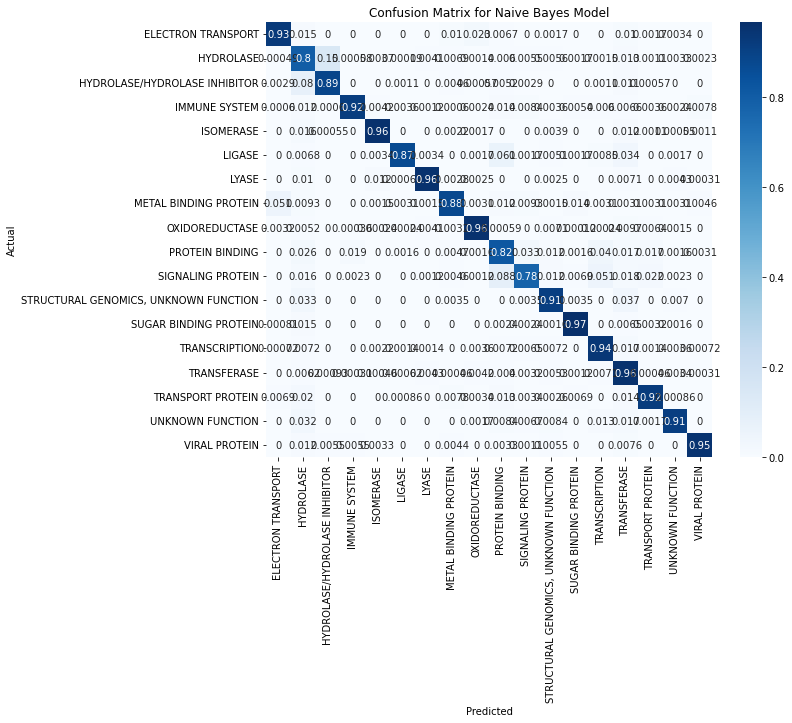

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

types = np.unique(train_res['classification'])
conf_mat = confusion_matrix(test_res['classification'], NB_pred, labels=types)
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=types, yticklabels=types)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix for Naive Bayes Model")
plt.show()

In [28]:
#Print F1 score metrics
from sklearn.metrics import classification_report

print(len(test_res['classification']), X_test_df.shape[0])
print(classification_report(test_res['classification'], NB_pred, target_names=types))

42834 42834
                                       precision    recall  f1-score   support

                   ELECTRON TRANSPORT       0.87      0.93      0.90       597
                            HYDROLASE       0.95      0.80      0.87     10280
        HYDROLASE/HYDROLASE INHIBITOR       0.51      0.89      0.65      1741
                        IMMUNE SYSTEM       0.98      0.92      0.95      1674
                            ISOMERASE       0.95      0.96      0.95      1806
                               LIGASE       0.96      0.87      0.91       588
                                LYASE       0.96      0.96      0.96      3219
                METAL BINDING PROTEIN       0.79      0.88      0.83       648
                       OXIDOREDUCTASE       0.99      0.96      0.97      8442
                      PROTEIN BINDING       0.65      0.82      0.73       645
                    SIGNALING PROTEIN       0.82      0.78      0.80       867
STRUCTURAL GENOMICS, UNKNOWN FUNCTION  

In [31]:
# Example input sequence and resolution values
input_sequence = "MGLNQEFPQGIDLTVGSSFQYGDMSGGDIFDFTVGHSSTTAQLNYQRDLRTVWTEARPADTFRFAKFDKLYLNLKKDPDQFKFPQVAATGDGWTREQTFTADTTSFHDYRGSQYGEQVYVLVTTKTVLKTGPAVVAIQNIDEVDFTVDEDGGARVLHVTGTMVTPSVSSYGIDLDMDFKRYALPDGTKPVVHPDTVDALVRNHARGTAIVGMVGGMQFTNIHACVGGGLLDLGKHAFANLAAVDKVVDGTTSTPGNAAFLQGLPAGSTGNLLLDQQIATGKKFGDQFGVPFVDRYFNELNKWKGAVLALPGSDPEMTKRNYLLSVTAAKLGSPVIRRLTGLTLPDAVQQESGYDGYGQVITIGNKTVQRLTPEFLSALESSEVGPIASVDEALSSYGLYQSWVYQTGGQDSRVVSAPVLQPEPYLNPDSDFAFEKGGSSVGLIPLWNSLKVPYLSYGFYSGVTRGKLSEFDKARVKTALGKSVQPIVSWDQGSVTQTYQEDDLYNTY"
input_resolution = 1.5

# Process the input sequence and resolution
input_data = pd.DataFrame({'sequence': [input_sequence], 'resolution': [input_resolution]})
input_data = input_data[input_data['resolution'].between(0, 2)]
input_seq = vect.transform(input_data['sequence'])

# Make predictions using the trained model
NB_pred = model.predict(input_seq)

# Output the predicted classification
print("Predicted classification:", NB_pred[0])


Predicted classification: HYDROLASE


## Reasons for Model Error
Proteins in general can be a type of enzyme, or a signaling protein, structural, and various other choices. A lof of proteins tend to share very similar characteristics, as some proteins are meant to bind in similar regions as others. For example, a Hydrolase enzyme and a Hydrolase inhibitor protein are going to have similar structures as they will target very similar areas. This is reflected in the confusion matrix and heat map. Gene regulator proteins will have a similarity to RNA binding proteins, DNA binding proteins, as well as transcription proteins. The biggest thing to note as well, as the model only uses features of 4 amino acids at most. The possibility of utilizing amino acids of higher degree in theory should be able to create an even higher accuracy.

## Future Work
There is definitely room for improvement for the model. Utilizing factors such as pH, molecular weight, and other components may be able to yield more information on family group. Furthermore, if possible, increase the length of the ngram_range to include more than just 4 characters to allow for higher interaction between the amino acids as reflected in reality